In [1]:
import random
import itertools

import chat as chat
import data as data
import utility as util

In [2]:
# Import our data -- the load_challenge_moves_csv function also processes the csv load so move / win probability are lists rather than strings
train_df = data.loader.load_challenge_moves_csv("data/chess_challenges_train_10k.csv", shuffle=True)
# print(train_df.info())
# train_df.head(2)

train_iterator = itertools.cycle(train_df.iterrows())

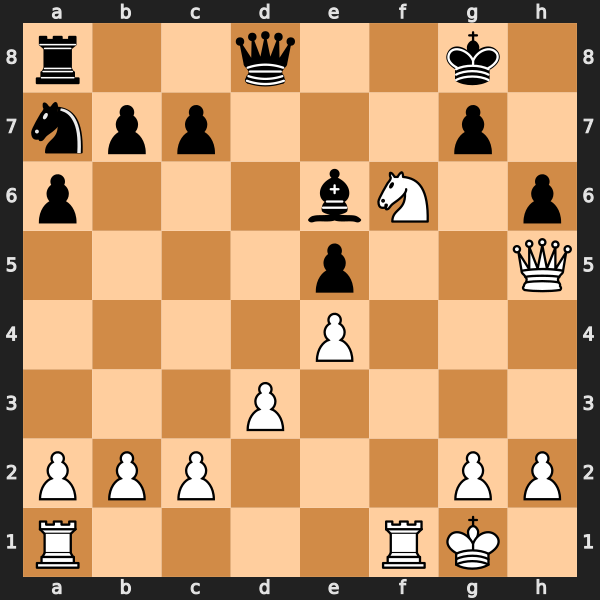

|   Move   |  Win Prob  |
-------------------------
|   g8h8   |   0.1577   |
|   g8f8   |   0.0863   |
|   g7f6   |   0.0793   |
|   d8f6   |   0.0560   |

--------------------------------------------------------------------------------
FEN:
r2q2k1/npp3p1/p3bN1p/4p2Q/4P3/3P4/PPP3PP/R4RK1 b - - 0 16
Legal Moves:
['g8f8', 'g8h8', 'd8f6', 'g7f6']
--------------------------------------------------------------------------------


In [14]:
# Can use this to view the data / win probs
_, row = next(train_iterator)
util.visualize_board_ipynb(row["FEN"], size=600)
util.print_top_moves(row["Move"], row["Win Probability"], top_n=None)
legal_moves = row["Move"]
random.shuffle(legal_moves)
print(f"\n{'-'*80}\nFEN:\n{row['FEN']}\nLegal Moves:\n{row['Move']}\n{'-'*80}")

In [4]:
def evaluate_chess_model(ollama_session, train_iterator, max_iters=None, max_timeout=30, verbose=False):   
    evaluation_results = {
        "num_attempts": 0,
        "legal_move_ranks": [],
        "num_legal_moves": 0,
        "error_illegal_move": 0,
        "error_timeout": 0,
        "error_generation": 0,
        "error_extraction": 0,
    }
    
    for iter in range(max_iters):
        evaluation_results["num_attempts"] += 1
        try:
            _, row = next(train_iterator)
            prompt = chat.format_prompt(row["FEN"], row["Move"])

            # Ensure our moves are sorted by win probability
            sorted_moves_probs = sorted(zip(row["Move"], row["Win Probability"]), key=lambda x: x[1], reverse=True)
            legal_moves, win_probs = zip(*sorted_moves_probs)
            
            # Generate a response from the model
            response, runtime_results = ollama_session.chat(user_prompt=prompt, timeout=max_timeout)
            
            if verbose:
                print(f"{'-'*100}\nPrompt:\n{prompt}\n\nResponse:\n{response}\n\nRuntime Results:\n{runtime_results}\n{'-'*100}\n")            

            move = chat.extract_answer(response)
            if move not in legal_moves:
                raise chat.IllegalMoveError(f"Model predicted illegal move: {move}")

            # If move in legal moves print probability / move ranking
            evaluation_results["num_legal_moves"] += 1
            move_idx = legal_moves.index(move)
            win_prob = win_probs[move_idx]
            move_rank = f"{move_idx+1}/{len(legal_moves)}"
            tps = runtime_results["generated_tokens"] / runtime_results["generation_duration"]
            print(f"[{iter+1:<4}/{max_iters:<4}] Move: {move} | Win Prob: {win_prob:.4f} | Move Rank: {move_rank:<5} | TPS: {tps:.2f}")
            evaluation_results['legal_move_ranks'].append((move_idx+1)/len(legal_moves))
            
        except Exception as e:
            print(f"[{iter+1:<4}/{max_iters:<4}] {type(e).__name__}: {e}")
            if type(e) == chat.IllegalMoveError:
                evaluation_results["error_illegal_move"] += 1
            elif type(e) == chat.TimeoutError:
                evaluation_results["error_timeout"] += 1
            elif type(e) == chat.GenerationError:
                evaluation_results["error_generation"] += 1
            elif type(e) == chat.ExtractionError:
                evaluation_results["error_extraction"] += 1
            else:
                print(f"Unknown Error: {e}")

    # At end print out results
    avg_rank = sum(evaluation_results['legal_move_ranks'])/len(evaluation_results['legal_move_ranks']) if len(evaluation_results['legal_move_ranks']) else 0
    print(f"\n{'='*60}\nAverage Legal Move Score (Rank / Total Moves):\n{avg_rank:.4f}\n")
    print(f"Evaluation Results:\n")
    for key, value in evaluation_results.items():
        if key != "legal_move_ranks":
            print(f"{key}: {value}")

In [ ]:
# Create a new Ollama Session to allow us to chat w/ various models
# IMPORTANT: Make sure to call `ollama serve` in your terminal to start the Ollama server
# [Lucas]: I'm personally getting ~70TPS on 1.5b and ~7TPS on 7b on my laptop. Most responses are between 1000-2000 tokens.
model_name = "deepseek-r1:1.5b"       # {deepseek-r1:1.5b, deepseek-r1:7b}
ollama_session = chat.OllamaSession(model=model_name, use_cuda=False)

evaluate_chess_model(
    ollama_session = ollama_session, 
    train_iterator = train_iterator, 
    max_iters = 20,
    max_timeout = 200,
    verbose = False
)

----------------------------------------------------------------------------------------------------
Prompt:
<FEN> 7R/4n1k1/4P3/1pp2B2/8/6P1/2r4P/6K1 w - - 3 50 </FEN> <legalmoves> [h2h3, h8f8, f5d3, f5e4, h8a8, g3g4, h8g8, h8b8, h8h6, h8c8, f5g6, h8h7, g1f1, h8h5, h8h4, f5h7, h8d8, g1h1, h8h3, h8e8, f5c2, f5h3, h2h4, f5g4] </legalmoves>

Response:
<think>
Okay, so I'm trying to figure out the best move for this chess position. The FEN is 7R/4n1k1/4P3/1pp2B2/8/6P1/2r4P/6K1 w - - 3 50. That means it's white's turn to move, and they have a few legal moves listed: h2h3, h8f8, f5d3, f5e4, h8a8, g3g4, h8g8, h8b8, h8h6, h8c8, f5g6, h8h7, g1f1, h8h5, h8h4, f5h7, h8d8, g1h1, h8h3, h8e8, f5c2, f5h3, h2h4, f5g4.

I know that in chess, the first move can be critical because it sets up the game. White usually controls the center with pawns or knights, but here they have a rook on 7th rank and some other pieces. Black's king is probably on h1, given the starting position after castling would make s